In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
train_df = pd.read_csv('/content/gdrive/My Drive/Kaggle/train.csv')

In [15]:
test_df = pd.read_csv('/content/gdrive/My Drive/Kaggle/test.csv')

In [7]:
print(f"Train shape: {train_df.shape}")
train_df.sample(5)

Train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
526,527,1,2,"Ridsdale, Miss. Lucy",female,50.0,0,0,W./C. 14258,10.5000,NaN,S
196,197,0,3,"Mernagh, Mr. Robert",male,NaN,0,0,368703,7.7500,NaN,Q
611,612,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S
256,257,1,1,"Thorne, Mrs. Gertrude Maybelle",female,NaN,0,0,PC 17585,79.2000,NaN,C
176,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S


In [8]:
print(f"Test shape: {test_df.shape}")
test_df.sample(5)

Test shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
378,1270,1,"Hipkins, Mr. William Edward",male,55.0,0,0,680,50.0000,C39,S
28,920,1,"Brady, Mr. John Bertram",male,41.0,0,0,113054,30.5000,A21,S
253,1145,3,"Salander, Mr. Karl Johan",male,24.0,0,0,7266,9.3250,NaN,S
386,1278,3,"Aronsson, Mr. Ernst Axel Algot",male,24.0,0,0,349911,7.7750,NaN,S
369,1261,2,"Pallas y Castello, Mr. Emilio",male,29.0,0,0,SC/PARIS 2147,13.8583,NaN,C


In [16]:
# concatena os datasets para analise exploratória
full_df = pd.concat(
    [
     train_df.drop(["PassengerId", "Survived"], axis=1),    # está eliminando as colunas do Id e do Survived (o label deste calculo)
     test_df.drop(["PassengerId"], axis=1),
    ]
)

In [17]:
y_train = train_df['Survived'].values

Verifica os valores nulos (check missed values)

In [12]:
full_df.isna().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

Dá pra ver que Age e Cabin tem muitos valores nulos.
Nós podemos ignorá-los tbm

In [18]:
full_df = full_df.drop(['Age', 'Cabin'], axis=1)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


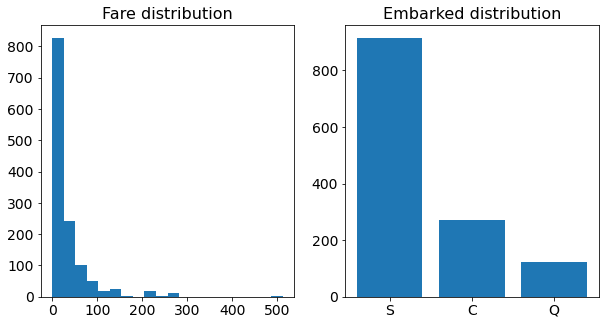

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(full_df["Fare"], bins=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Fare distribution", fontsize=16)

plt.subplot(1, 2, 2)
embarked_info = full_df["Embarked"].value_counts()
plt.bar(embarked_info.index, embarked_info.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Embarked distribution", fontsize=16);

Para a coluna Embarked, a maioria está preenchido com "S", então vamos usar esse valor para as linhas que estão nulas
Para a coluna Fare, vamos usar a média

In [19]:
full_df['Fare'].fillna(full_df['Fare'].mean(), inplace=True)
full_df['Embarked'].fillna('S', inplace=True)

In [16]:
full_df.isna().sum()

Pclass      0
Name        0
Sex         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [20]:
# mapeia o sexo
map_sex = {
    'male': 1,
    'female': 0
}

full_df['Sex'] = full_df['Sex'].map(map_sex).astype(int)

In [21]:
# Arruma os valores do campo Ticket
from sklearn.preprocessing import LabelEncoder
full_df['TicketNumber'] = full_df['Ticket'].str.split()
full_df['TicketNumber'] = full_df['TicketNumber'].str[-1]
full_df['TicketNumber'] = LabelEncoder().fit_transform(full_df['TicketNumber'])
full_df = full_df.drop(['Ticket'], axis=1)

In [30]:
full_df = full_df.drop(['Name'], axis=1)

In [34]:
# mapeia o Embarked
map_Embarked = {
    'S': 1,
    'C': 2,
    'Q': 3
}

full_df['Embarked'] = full_df['Embarked'].map(map_Embarked).astype(int)

In [35]:
full_df.sample(10)

,Pclass,Sex,SibSp,Parch,Fare,Embarked,TicketNumber
8,3,0,0,0,7.2292,2,359
876,3,1,0,0,9.8458,1,907
356,1,0,0,1,55.0000,1,40
232,3,1,1,0,6.4958,1,450
761,3,1,0,0,7.1250,1,456
32,3,0,0,0,7.7500,3,567
31,2,1,2,0,31.5000,1,498
123,3,1,0,0,7.2500,1,862
296,3,1,0,0,7.2292,2,396
138,3,0,0,0,8.0500,1,855


Divide o dataset em treino/teste

In [36]:
X_train = full_df[:y_train.shape[0]]
X_test = full_df[y_train.shape[0]:]

In [23]:
print(f"Train X shape: {X_train.shape}")
print(f"Train y shape: {y_train.shape}")   # foi definido lá em cima
print(f"Test X shape: {X_test.shape}")

Train X shape: (891, 8)
Train y shape: (891,)
Test X shape: (418, 8)


In [23]:
import seaborn as sns
#import catboost as cb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [7]:
pip install catboost

     |████████████████████████████████| 66.2MB 60kB/s 


In [27]:
import catboost as cb
import random
import os

In [25]:

cros_valid_scores = {}

In [28]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    

SEED = 42
set_seed(SEED)

In [43]:
from sklearn.metrics import make_scorer
accuracy = make_scorer(accuracy_score)

Árvore de Decisão (decision tree)

In [44]:
parameters = {
    'max_depth': [3, 5, 7, 9, 11, 13],
}

model_decision_tree = DecisionTreeClassifier(
    random_state=SEED,  # equivale a 42
    class_weight='balanced',
)

model_decision_tree = GridSearchCV(
    model_decision_tree,
    parameters,
    cv=5,
    scoring=accuracy
)

model_decision_tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'ma

In [45]:
categorical_columns = ['Sex', 'Embarked', 'Title', 'TicketNumber', 'IsAlone']

In [46]:
print(f'Best parameters: {model_decision_tree.best_params_}')
print(f'Best accuracy score: {model_decision_tree.best_score_}')

Best parameters: {'max_depth': 9}
Best accuracy score: 0.8002322515849603


In [41]:
cros_valid_scores['decision_tree'] = model_decision_tree.best_score_

In [42]:
cros_valid_scores

{'decision_tree': 0.8002322515849603}

Random Forest

In [47]:
parameters = {
    'n_estimators': [5, 10, 15, 20, 25],
    'max_depth': [3, 5, 7, 9, 11, 13]
}

model_random_forest = RandomForestClassifier(
    random_state=SEED,   # equivale a 42
    class_weight='balanced'
)

model_random_forest = GridSearchCV(
    model_random_forest,
    parameters,
    cv=5,
    scoring=accuracy
)

model_random_forest.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                            

In [48]:
print(f'Best parameters: {model_random_forest.best_params_}')
print(f'Best accuracy score: {model_random_forest.best_score_}')

Best parameters: {'max_depth': 9, 'n_estimators': 10}
Best accuracy score: 0.832803967108154


In [50]:
cros_valid_scores['random_forest'] = model_random_forest.best_score_
cros_valid_scores

{'decision_tree': 0.8002322515849603, 'random_forest': 0.832803967108154}

**XGBoost**

O XGBoost é um algoritmo de aprendizado de máquina, baseado em árvore de decisão e que utiliza uma estrutura de Gradient boosting

In [ ]:
import xgboost as xgb

In [54]:
parameters = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

model_xgb = xgb.XGBClassifier(
    random_state=SEED  # equivale a 42
)

model_xgb = GridSearchCV(
    model_xgb,
    parameters,
    cv=5,
    scoring=accuracy
)

model_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [5, 10, 15, 20, 25, 50

In [55]:
print(f'Best parameters: {model_xgb.best_params_}')
print(f'Best accuracy score: {model_xgb.best_score_}')

Best parameters: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 100}
Best accuracy score: 0.8215931203314293


In [56]:
cros_valid_scores['xgboost'] = model_xgb.best_score_
cros_valid_scores

{'decision_tree': 0.8002322515849603,
 'random_forest': 0.832803967108154,
 'xgboost': 0.8215931203314293}

**LightGBM**

Gradient boosting da Microsoft Research

In [57]:
import lightgbm as lgbm

In [60]:
parameters = {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [7, 15, 31],
}

model_lgbm = lgbm.LGBMClassifier(
    random_state=SEED,   # equivale a 42
    class_weight='balanced'
)

model_lgbm = GridSearchCV(
    model_lgbm,
    parameters,
    cv=5,
    scoring=accuracy
)

model_lgbm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.0

In [61]:
print(f'Best parameters: {model_lgbm.best_params_}')
print(f'Best accuracy score: {model_lgbm.best_score_}')

Best parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 7}
Best accuracy score: 0.8025045508756513


In [62]:
cros_valid_scores['lightgbm'] = model_lgbm.best_score_
cros_valid_scores

{'decision_tree': 0.8002322515849603,
 'lightgbm': 0.8025045508756513,
 'random_forest': 0.832803967108154,
 'xgboost': 0.8215931203314293}

**CATBoost**

Algoritmo de Gradient boosting da Yandex Technology

In [65]:
parameters = {
     'iterations': [5, 10, 15, 20, 25, 50, 100],
     'learning_rate': [0.01, 0.05, 0.1],
     'depth': [3, 5, 7, 9, 11, 13]
}

model_catboost = cb.CatBoostClassifier(
    verbose=False,          ## aqui somente este parametro como fixo
)

model_catboost= GridSearchCV(
    model_catboost,
    parameters,
    cv=5,
    scoring=accuracy
)

model_catboost.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc2305f9f60>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [3, 5, 7, 9, 11, 13],
                         'iterations': [5, 10, 15, 20, 25, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_score), verbose=0)

In [67]:
print(f'Best parameters: {model_catboost.best_params_}')
print(f'Best accuracy score: {model_catboost.best_score_}')

Best parameters: {'depth': 13, 'iterations': 100, 'learning_rate': 0.1}
Best accuracy score: 0.8215554579122466


In [69]:
cros_valid_scores['catboost'] = model_catboost.best_score_
cros_valid_scores

{'catboost': 0.8215554579122466,
 'decision_tree': 0.8002322515849603,
 'lightgbm': 0.8025045508756513,
 'random_forest': 0.832803967108154,
 'xgboost': 0.8215931203314293}

Regressão logística

In [71]:
%%time

parameters = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2']
}

model_log_regression = LogisticRegression(
    random_state=SEED,   # 42
    class_weight = 'balanced',
    solver='liblinear'
)

model_log_regression = GridSearchCV(
    model_log_regression,
    parameters,
    cv=5,
    scoring=accuracy
)

model_log_regression.fit(
    X_train,
    y_train
)

CPU times: user 215 ms, sys: 1.84 ms, total: 217 ms
Wall time: 223 ms


In [72]:
print(f'Best parameters: {model_log_regression.best_params_}')
print(f'Best accuracy score: {model_log_regression.best_score_}')

Best parameters: {'C': 0.1, 'penalty': 'l1'}
Best accuracy score: 0.7766618542464376


In [73]:
cros_valid_scores['log_regression'] = model_log_regression.best_score_
cros_valid_scores

{'catboost': 0.8215554579122466,
 'decision_tree': 0.8002322515849603,
 'lightgbm': 0.8025045508756513,
 'log_regression': 0.7766618542464376,
 'random_forest': 0.832803967108154,
 'xgboost': 0.8215931203314293}

Submission

In [74]:
pd.DataFrame(cros_valid_scores, index=['cros_valid_scores']).T

,cros_valid_scores
decision_tree,0.800232
random_forest,0.832804
xgboost,0.821593
lightgbm,0.802505
catboost,0.821555
log_regression,0.776662


In [75]:
def create_submission(model, X_test, test_passenger_id, model_name):
    y_pred_test = model.predict_proba(X_test)[:, 1]
    submission = pd.DataFrame(
        {
            'PassengerId': test_passenger_id, 
            'Survived': (y_pred_test >= 0.5).astype(int),
        }
    )
    submission.to_csv(f"submission_{model_name}.csv", index=False)
    
    return y_pred_test

In [77]:
test_pred_decision_tree = create_submission(
    model_decision_tree, X_test, test_df["PassengerId"], "decision_tree"
)
test_pred_random_forest = create_submission(
    model_random_forest, X_test, test_df["PassengerId"], "random_forest"
)
test_pred_xgboost = create_submission(
    model_xgb, X_test, test_df["PassengerId"], "xgboost"
)
test_pred_lightgbm = create_submission(
    model_lgbm, X_test, test_df["PassengerId"], "lightgbm"
)
test_pred_catboost = create_submission(
    model_catboost, X_test, test_df["PassengerId"], "catboost"
)

In [78]:
test_pred_merged = (
    test_pred_decision_tree + 
    test_pred_random_forest + 
    test_pred_xgboost + 
    test_pred_lightgbm + 
    test_pred_catboost
)
test_pred_merged = np.round(test_pred_merged / 5)

In [79]:
submission = pd.DataFrame(
    {
        'PassengerId': test_df["PassengerId"], 
        'Survived': test_pred_merged.astype(int),  # a média das medidas
    }
)
submission.to_csv(f"submission_merged.csv", index=False)

In [80]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
